References :  


*   https://chat.openai.com/ 
*   https://pytorch.org/ 
*   https://mazhar-hussain.medium.com/semantic-image-segmentation-with-python-pytorch-c948aabceced 

In [ ]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models.segmentation import fcn_resnet50

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
!pip install wandb
import wandb

In [ ]:
class ToIntTensor(transforms.ToTensor):
    """A custom transform that replaces "ToTensor". ToTensor always converts to a 
    a float in range [0,1]. This one converts to an integer, which can represent
    our class labels per pixel in an image segmentation problem"""
    def __call__(self, pic):
        tensor = super().__call__(pic)
        tensor = (tensor * 255).to(torch.int64)
        return tensor

def get_voc_dataloader(batch_size=4):
    """Get the VOC 2007 segmentation dataset and return PyTorch 
    dataloaders for both training and validation. 
    """
    # Define image transforms for both the input image AND the "label" image
    # Resize/crop images to be all the same size, a power of 2
    # Transform the label and image in the same way when changing size
    image_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    label_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        ToIntTensor()
    ])

    # This downloads the data automatically and creates a "dataset" object that applies the transforms
    data_dir = "~/Downloads/"  # TODO: Specify path to save data
    train_dataset = datasets.VOCSegmentation(data_dir, year='2007', image_set='train', download=True, transform=image_transforms, target_transform=label_transforms)
    val_dataset = datasets.VOCSegmentation(data_dir, year='2007', image_set='val', download=True, transform=image_transforms, target_transform=label_transforms)

    # Create data loaders for the datasets - necessary for efficient training
    train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_dl, val_dl

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps') if torch.backends.mps.is_available() else device

# Define some hyperparameters
batch_size = 64  # Adjust batch size to make maximal use of GPU without running out of memory 
epochs = 50
learning_rate = 0.001
n_class = 21  # The class labels are 0...20. The label "255" is interpreted as a "mask" meant to be ignored

# Load model and data
model = fcn_resnet50(n_class=n_class).to(device)
train_dl, val_dl = get_voc_dataloader(batch_size=batch_size)

# Training loop
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.01)


Using downloaded and verified file: /Users/niyathiallu/Downloads/VOCtrainval_06-Nov-2007.tar
Extracting /Users/niyathiallu/Downloads/VOCtrainval_06-Nov-2007.tar to /Users/niyathiallu/Downloads/
Using downloaded and verified file: /Users/niyathiallu/Downloads/VOCtrainval_06-Nov-2007.tar
Extracting /Users/niyathiallu/Downloads/VOCtrainval_06-Nov-2007.tar to /Users/niyathiallu/Downloads/


In [ ]:
def train_epoch(model, train_dl, val_dl, optimizer, device):
    """
    Train one epoch of model with optimizer, using data from train_dl.
    Do training on "device". 
    Return the train and validation loss and validation accuracy.
    """
    criterion = nn.CrossEntropyLoss(ignore_index=255)

    model.train()
    train_loss = 0.0

    for inputs, labels in train_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Squeeze the label tensor
        labels = labels.squeeze(dim=1)

        # Calculate the loss
        loss = criterion(outputs['out'], labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    # Calculate the average training loss
    train_loss /= len(train_dl.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Squeeze the label tensor
            labels = labels.squeeze(dim=1)

            # Calculate the loss
            loss = criterion(outputs['out'], labels)
            val_loss += loss.item() * inputs.size(0)

            # Calculate the accuracy
            _, predicted = torch.max(outputs['out'], 1)
            total += labels.numel()
            correct += (predicted == labels).sum().item()

            print(f"predicted shape: {predicted.shape}, labels shape: {labels.shape}")
            print(f"Total labels size {total}")
            print(f"Correctly predicted Values {correct}")
            # print(f"predicted values: {predicted}, labels values: {labels}")

    # Calculate the average validation loss and accuracy
    val_loss /= len(val_dl.dataset)
    accuracy = correct / total
    print(f"Accuracy : {accuracy*100}")

    return train_loss, val_loss, accuracy



In [ ]:
wandb.init(project='ML-CV-HW2-Baseline')

wandb: Currently logged in as: alluniyathi. Use `wandb login --relogin` to force relogin


In [ ]:
 config = wandb.config
 config.learning_rate = 0.01
 config.weight_decay = 0.01
 config.momentum = 0.9 
 config.method = 'Baseline'

In [ ]:
train_losses, val_losses, accuracy_list = [], [], []
for epoch in range(epochs):
    print(f"Epoch : {epoch}")
    train_loss, val_loss, accuracy = train_epoch(model, train_dl, val_dl, optimizer, device) 
    # Print the loss, and store for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accuracy_list.append(accuracy)
    wandb.log({         
        'train_loss': train_loss,
        'val_loss': val_loss,
        'accuracy': accuracy         
        }) 
wandb.finish()

Epoch : 0
predicted shape: torch.Size([64, 256, 256]), labels shape: torch.Size([64, 256, 256])
Total labels size 4194304
Correctly predicted Values 260900
predicted shape: torch.Size([64, 256, 256]), labels shape: torch.Size([64, 256, 256])
Total labels size 8388608
Correctly predicted Values 499826
predicted shape: torch.Size([64, 256, 256]), labels shape: torch.Size([64, 256, 256])
Total labels size 12582912
Correctly predicted Values 821604
predicted shape: torch.Size([21, 256, 256]), labels shape: torch.Size([21, 256, 256])
Total labels size 13959168
Correctly predicted Values 896268
Accuracy : 6.420640542473592
Epoch : 1
predicted shape: torch.Size([64, 256, 256]), labels shape: torch.Size([64, 256, 256])
Total labels size 4194304
Correctly predicted Values 1173924
predicted shape: torch.Size([64, 256, 256]), labels shape: torch.Size([64, 256, 256])
Total labels size 8388608
Correctly predicted Values 2328931
predicted shape: torch.Size([64, 256, 256]), labels shape: torch.Size([

wandb: Network error (ConnectTimeout), entering retry loop.


predicted shape: torch.Size([64, 256, 256]), labels shape: torch.Size([64, 256, 256])
Total labels size 4194304
Correctly predicted Values 3106476
predicted shape: torch.Size([64, 256, 256]), labels shape: torch.Size([64, 256, 256])
Total labels size 8388608
Correctly predicted Values 6345048
predicted shape: torch.Size([64, 256, 256]), labels shape: torch.Size([64, 256, 256])
Total labels size 12582912
Correctly predicted Values 9537507
predicted shape: torch.Size([21, 256, 256]), labels shape: torch.Size([21, 256, 256])
Total labels size 13959168
Correctly predicted Values 10587735
Accuracy : 75.84789437307438
Epoch : 12
predicted shape: torch.Size([64, 256, 256]), labels shape: torch.Size([64, 256, 256])
Total labels size 4194304
Correctly predicted Values 3093849
predicted shape: torch.Size([64, 256, 256]), labels shape: torch.Size([64, 256, 256])
Total labels size 8388608
Correctly predicted Values 6312069
predicted shape: torch.Size([64, 256, 256]), labels shape: torch.Size([64, 

accuracy,▁▃▅▇▇▇▇█████████████████████████████████
train_loss,▄█▆▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.79921
train_loss,0.21665
val_loss,0.50529


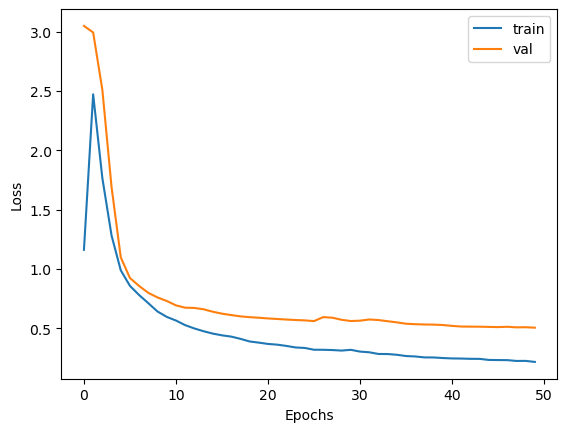

In [ ]:
# Plot train and validation loss
plt.plot(range(50), train_losses_baseline, label='train')
plt.plot(range(50), val_losses_baseline, label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
train_losses_baseline = train_losses
val_losses_baseline = val_losses
accuracy_list_baseline = accuracy_list

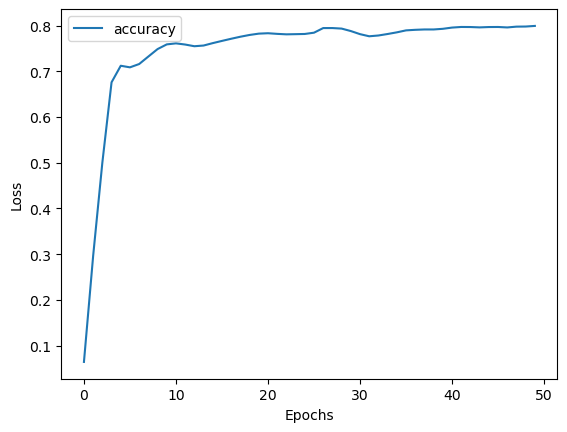

In [ ]:
# Plot train and validation loss
plt.plot(range(50), accuracy_list_baseline, label='accuracy')
# plt.plot(range(50), val_losses, label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


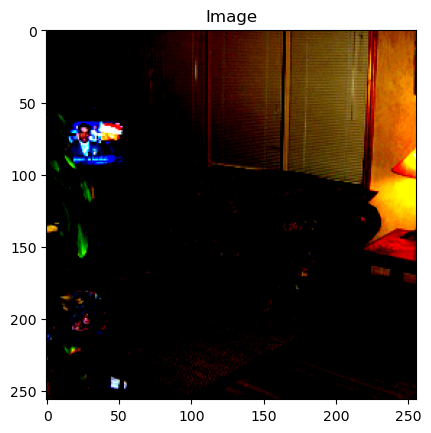

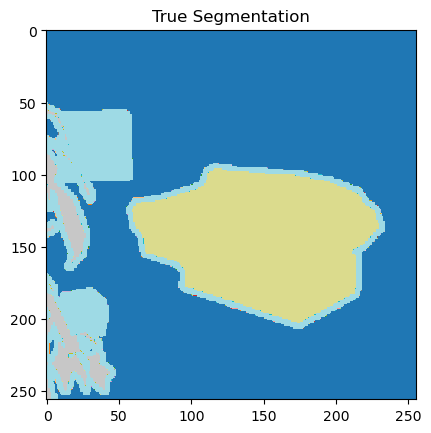

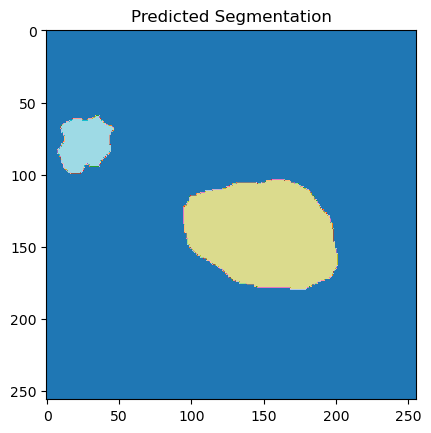

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the colormap
n_class = 21  # Number of segmentation classes
cmap = plt.cm.get_cmap('tab20', n_class + 1)  # tab20 is a colormap with 20 distinct colors

# Get an example image and its segmentation
inputs, labels = next(iter(val_dl))
inputs, labels = inputs.to(device), labels.to(device)
outputs = model(inputs)['out']
labels = labels.squeeze(1)  # Remove the channel dimension
predicted_label = outputs.argmax(axis=1)  # Get the class with the highest probability
predicted_label = predicted_label.cpu().numpy()  # Convert to numpy array
inputs = inputs.cpu().numpy()  # Convert input tensor to numpy array

# Print the image, true segmentation, and predicted segmentation
idx = np.random.randint(0, inputs.shape[0])
plt.imshow(inputs[idx].transpose(1, 2, 0))
plt.title("Image")
plt.show()

plt.imshow(labels[idx].cpu().numpy(), cmap=cmap, vmin=0, vmax=n_class)
plt.title("True Segmentation")
plt.show()

plt.imshow(predicted_label[idx], cmap=cmap, vmin=0, vmax=n_class)
plt.title("Predicted Segmentation")
plt.show()



In [ ]:
# Feel free to use the outputs of my code for the confidence calibration plot and ECE
# Here I run the model on all points in the validation set. 
# I collect predictions on all pixels, excluding masks, and flatten them. 

model.eval()
with torch.no_grad():
    all_acc = []
    all_conf = []
    for i, (inputs, labels) in enumerate(val_dl):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)['out']
        labels = labels.squeeze(1).flatten(start_dim=1)  # batch, h, w  - integer values 0..20 or 255 for mask
        predicted_label = outputs.argmax(axis=1).flatten(start_dim=1)  # batch, h, w, integer 0...20  
        probs = outputs.softmax(axis=1)  # batch, n_class, h, w
        confidence = probs.max(axis=1).values.flatten(start_dim=1)  # Confidence in predicted label
        accuracy = (predicted_label == labels)
        accuracy_filter = accuracy[labels < 255]
        confidence_filter = confidence[labels < 255]
        all_acc.append(accuracy_filter)
        all_conf.append(confidence_filter)
        
all_acc = torch.cat(all_acc).cpu().numpy()  # accuracy to predict pixel class across all pixels and images, excluding masks
all_conf = torch.cat(all_conf).cpu().numpy()  # confidence of prediction for each pixel and image, excluding masks
        
# Get the average confidence and accuracy for points within different confidence ranges
bins = 10
bin_boundaries = np.linspace(0, 1, bins + 1)
bin_lowers = bin_boundaries[:-1]
bin_uppers = bin_boundaries[1:]
bin_centers = 0.5*(bin_lowers+bin_uppers)
bin_acc = np.zeros(bins)  # Store accuracy within each bin
bin_conf = np.zeros(bins)  # Store confidence within each bin
bin_frac = np.zeros(bins)  # Store the fraction of data in included in each bin
for i in range(bins):
    in_bin = np.logical_and(all_conf >= bin_lowers[i], all_conf < bin_uppers[i])
    bin_frac[i] = np.sum(in_bin) / len(all_conf)  # fraction of points in bin
    if bin_frac[i] > 0.:
        bin_acc[i] = all_acc[in_bin].mean()  # average accuracy in this bin
        bin_conf[i] = all_conf[in_bin].mean()  # average confidence in this bin
    else:
        bin_acc[i], bin_conf[i] = 0, 0  # If no points are in this bin, they don't contribute to ECE anyway

/var/folders/lq/4zqzmx9d3nd4j_bl1z31vd0h0000gn/T/ipykernel_32772/798153022.py:17: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  accuracy_filter = accuracy[labels < 255]


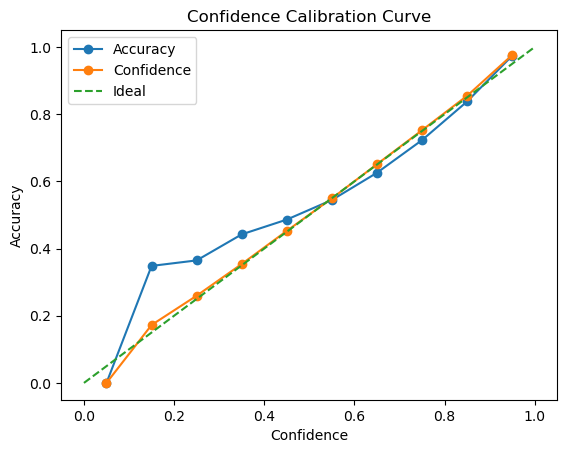

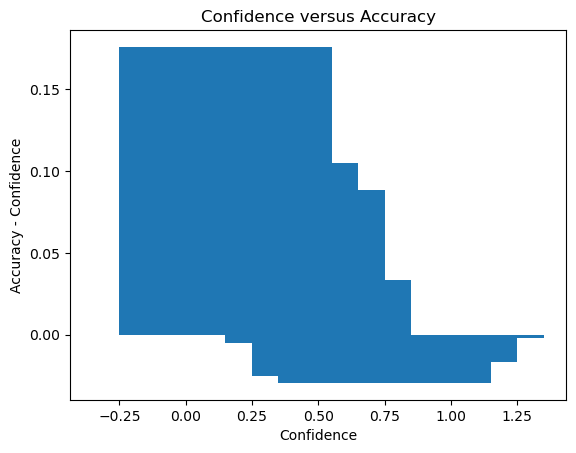

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss

# Calculate ECE
ece = np.sum(bin_frac * np.abs(bin_acc - bin_conf)) / np.sum(bin_frac)

# Plot confidence calibration curve
fig, ax = plt.subplots()
ax.plot(bin_centers, bin_acc, marker='o', label='Accuracy')
ax.plot(bin_centers, bin_conf, marker='o', label='Confidence')
ax.plot([0, 1], [0, 1], linestyle='--', label='Ideal')
ax.set_xlabel('Confidence')
ax.set_ylabel('Accuracy')
ax.set_title('Confidence Calibration Curve')
ax.legend()

# Plot confidence versus accuracy bar chart
fig, ax = plt.subplots()
ax.bar(bin_centers, bin_acc - bin_conf)
ax.set_xlabel('Confidence')
ax.set_ylabel('Accuracy - Confidence')
ax.set_title('Confidence versus Accuracy')
plt.show()



# DataAugmentation

In [ ]:
class ToIntTensor(transforms.ToTensor):
    """A custom transform that replaces "ToTensor". ToTensor always converts to a 
    a float in range [0,1]. This one converts to an integer, which can represent
    our class labels per pixel in an image segmentation problem"""
    def __call__(self, pic):
        tensor = super().__call__(pic)
        tensor = (tensor * 255).to(torch.int64)
        return tensor

def get_voc_dataloader(batch_size=4):
    """Get the VOC 2007 segmentation dataset and return PyTorch 
    dataloaders for both training and validation. 
    """
    # Define image transforms for both the input image AND the "label" image
    # Resize/crop images to be all the same size, a power of 2
    # Transform the label and image in the same way when changing size
    image_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),  # convert the images to tensors (floats in [0,1])
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    label_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        ToIntTensor()
    ])

    # This downloads the data automatically and creates a "dataset" object that applies the transforms
    data_dir = "~/Downloads/"  # TODO: Specify path to save data
    train_dataset = datasets.VOCSegmentation(data_dir, year='2007', image_set='train', download=True, transform=image_transforms, target_transform=label_transforms)
    val_dataset = datasets.VOCSegmentation(data_dir, year='2007', image_set='val', download=True, transform=image_transforms, target_transform=label_transforms)

    # Create data loaders for the datasets - necessary for efficient training
    train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_dl, val_dl

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps') if torch.backends.mps.is_available() else device

# Define some hyperparameters
batch_size = 64  # Adjust batch size to make maximal use of GPU without running out of memory 
epochs = 50
learning_rate = 0.01
n_class = 21  # The class labels are 0...20. The label "255" is interpreted as a "mask" meant to be ignored

# Load model and data
model = fcn_resnet50(n_class=n_class).to(device)
train_dl, val_dl = get_voc_dataloader(batch_size=batch_size)

# Training loop
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.01)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.)


Using downloaded and verified file: /Users/niyathiallu/Downloads/VOCtrainval_06-Nov-2007.tar
Extracting /Users/niyathiallu/Downloads/VOCtrainval_06-Nov-2007.tar to /Users/niyathiallu/Downloads/
Using downloaded and verified file: /Users/niyathiallu/Downloads/VOCtrainval_06-Nov-2007.tar
Extracting /Users/niyathiallu/Downloads/VOCtrainval_06-Nov-2007.tar to /Users/niyathiallu/Downloads/


In [ ]:
import torchvision.transforms as transforms

# Define the transforms for data augmentation
train_transforms = transforms.Compose([
    # transforms.RandomResizedCrop(size=224, scale=(0.8, 1.2)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=(-10, 10)),
    transforms.ColorJitter(brightness=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Modify the train and validation dataloaders to use data augmentation
train_dl.dataset.transform = train_transforms

In [ ]:
def train_epoch(model, train_dl, val_dl, optimizer, device):
    """
    Train one epoch of model with optimizer, using data from train_dl.
    Do training on "device". 
    Return the train and validation loss and validation accuracy.
    """
    criterion = nn.CrossEntropyLoss(ignore_index=255)

    model.train()
    train_loss = 0.0

    for inputs, labels in train_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Squeeze the label tensor
        labels = labels.squeeze(dim=1)

        # Calculate the loss
        loss = criterion(outputs['out'], labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    # Calculate the average training loss
    train_loss /= len(train_dl.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Squeeze the label tensor
            labels = labels.squeeze(dim=1)

            # Calculate the loss
            loss = criterion(outputs['out'], labels)
            val_loss += loss.item() * inputs.size(0)

            # Calculate the accuracy
            _, predicted = torch.max(outputs['out'], 1)
            total += labels.numel()
            correct += (predicted == labels).sum().item()

            # print(f"predicted shape: {predicted.shape}, labels shape: {labels.shape}")
            # print(f"Total labels size {total}")
            # print(f"Correctly predicted Values {correct}")
            # print(f"predicted values: {predicted}, labels values: {labels}")

    # Calculate the average validation loss and accuracy
    val_loss /= len(val_dl.dataset)
    accuracy = correct / total
    
    print(f"Accuracy is {accuracy*100}")

    return train_loss, val_loss, accuracy

In [ ]:
wandb.init(project='ML-CV-HW2-Baseline')

In [ ]:
config = wandb.config
config.learning_rate = 0.01
config.weight_decay = 0.01
config.momentum = 0.9 
config.method = 'Data Augmentation'

In [ ]:
train_losses, val_losses, accuracy_list = [], [], []
for epoch in range(epochs):
    print(f"Epoch is {epoch}")
    train_loss, val_loss, accuracy = train_epoch(model, train_dl, val_dl, optimizer, device) 
    # Print the loss, and store for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accuracy_list.append(accuracy)
    wandb.log({ 
        'train_loss': train_loss,
        'val_loss': val_loss,
        'accuracy': accuracy         
        }) 
wandb.finish()

Epoch is 0
Accuracy is 33.94463051093016
Epoch is 1
Accuracy is 70.23715166978432
Epoch is 2
Accuracy is 68.93980357568589
Epoch is 3
Accuracy is 75.86250126082012
Epoch is 4
Accuracy is 77.07993055173489
Epoch is 5
Accuracy is 76.39344981018927
Epoch is 6
Accuracy is 78.39042412842943
Epoch is 7
Accuracy is 77.84809954289538
Epoch is 8
Accuracy is 76.61672959305311
Epoch is 9
Accuracy is 77.7293818657387
Epoch is 10
Accuracy is 79.46529477974619
Epoch is 11
Accuracy is 79.9153144370782
Epoch is 12
Accuracy is 79.69045862905297
Epoch is 13
Accuracy is 79.15476051294748
Epoch is 14
Accuracy is 79.03637236832452
Epoch is 15
Accuracy is 80.44449354001614
Epoch is 16
Accuracy is 81.42325531149135
Epoch is 17
Accuracy is 81.2448564269733
Epoch is 18
Accuracy is 80.49433175386957
Epoch is 19
Accuracy is 80.79561761847125
Epoch is 20
Accuracy is 81.54580559529049
Epoch is 21
Accuracy is 81.4839824264598
Epoch is 22
Accuracy is 81.01740017743178
Epoch is 23
Accuracy is 81.09365114023987
Epoch 

accuracy,▁▆▆▇▇▇▇▇████████████████████████████████
train_loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.82324
train_loss,0.08216
val_loss,0.46515


In [ ]:
train_losses_data_augmentation = train_losses
val_losses_data_augmentation = val_losses
accuracy_list_data_augmentation = accuracy_list

In [ ]:
# Plot train and validation loss
plt.plot(range(50), train_losses, label='train')
plt.plot(range(50), val_losses, label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Plot train and validation loss
plt.plot(range(50), accuracy_list, label='accuracy')
# plt.plot(range(50), val_losses, label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the colormap
n_class = 21  # Number of segmentation classes
cmap = plt.cm.get_cmap('tab20', n_class + 1)  # tab20 is a colormap with 20 distinct colors

# Get an example image and its segmentation
inputs, labels = next(iter(val_dl))
inputs, labels = inputs.to(device), labels.to(device)
outputs = model(inputs)['out']
labels = labels.squeeze(1)  # Remove the channel dimension
predicted_label = outputs.argmax(axis=1)  # Get the class with the highest probability
predicted_label = predicted_label.cpu().numpy()  # Convert to numpy array
inputs = inputs.cpu().numpy()  # Convert input tensor to numpy array

# Print the image, true segmentation, and predicted segmentation
idx = np.random.randint(0, inputs.shape[0])
plt.imshow(inputs[idx].transpose(1, 2, 0))
plt.title("Image")
plt.show()

plt.imshow(labels[idx].cpu().numpy(), cmap=cmap, vmin=0, vmax=n_class)
plt.title("True Segmentation")
plt.show()

plt.imshow(predicted_label[idx], cmap=cmap, vmin=0, vmax=n_class)
plt.title("Predicted Segmentation")
plt.show()

In [ ]:
# Feel free to use the outputs of my code for the confidence calibration plot and ECE
# Here I run the model on all points in the validation set. 
# I collect predictions on all pixels, excluding masks, and flatten them. 

model.eval()
with torch.no_grad():
    all_acc = []
    all_conf = []
    for i, (inputs, labels) in enumerate(val_dl):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)['out']
        labels = labels.squeeze(1).flatten(start_dim=1)  # batch, h, w  - integer values 0..20 or 255 for mask
        predicted_label = outputs.argmax(axis=1).flatten(start_dim=1)  # batch, h, w, integer 0...20  
        probs = outputs.softmax(axis=1)  # batch, n_class, h, w
        confidence = probs.max(axis=1).values.flatten(start_dim=1)  # Confidence in predicted label
        accuracy = (predicted_label == labels)
        accuracy_filter = accuracy[labels < 255]
        confidence_filter = confidence[labels < 255]
        all_acc.append(accuracy_filter)
        all_conf.append(confidence_filter)
        
all_acc = torch.cat(all_acc).cpu().numpy()  # accuracy to predict pixel class across all pixels and images, excluding masks
all_conf = torch.cat(all_conf).cpu().numpy()  # confidence of prediction for each pixel and image, excluding masks
        
# Get the average confidence and accuracy for points within different confidence ranges
bins = 10
bin_boundaries = np.linspace(0, 1, bins + 1)
bin_lowers = bin_boundaries[:-1]
bin_uppers = bin_boundaries[1:]
bin_centers = 0.5*(bin_lowers+bin_uppers)
bin_acc = np.zeros(bins)  # Store accuracy within each bin
bin_conf = np.zeros(bins)  # Store confidence within each bin
bin_frac = np.zeros(bins)  # Store the fraction of data in included in each bin
for i in range(bins):
    in_bin = np.logical_and(all_conf >= bin_lowers[i], all_conf < bin_uppers[i])
    bin_frac[i] = np.sum(in_bin) / len(all_conf)  # fraction of points in bin
    if bin_frac[i] > 0.:
        bin_acc[i] = all_acc[in_bin].mean()  # average accuracy in this bin
        bin_conf[i] = all_conf[in_bin].mean()  # average confidence in this bin
    else:
        bin_acc[i], bin_conf[i] = 0, 0  # If no points are in this bin, they don't contribute to ECE anyway

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss

# Calculate ECE
ece = np.sum(bin_frac * np.abs(bin_acc - bin_conf)) / np.sum(bin_frac)

# Plot confidence calibration curve
fig, ax = plt.subplots()
ax.plot(bin_centers, bin_acc, marker='o', label='Accuracy')
ax.plot(bin_centers, bin_conf, marker='o', label='Confidence')
ax.plot([0, 1], [0, 1], linestyle='--', label='Ideal')
ax.set_xlabel('Confidence')
ax.set_ylabel('Accuracy')
ax.set_title('Confidence Calibration Curve')
ax.legend()

# Plot confidence versus accuracy bar chart
fig, ax = plt.subplots()
ax.bar(bin_centers, bin_acc - bin_conf)
ax.set_xlabel('Confidence')
ax.set_ylabel('Accuracy - Confidence')
ax.set_title('Confidence versus Accuracy')
plt.show()


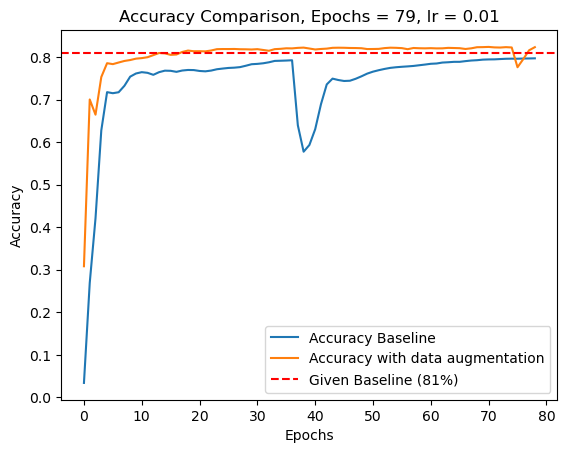

In [ ]:
import matplotlib.pyplot as plt

# Plotting the accuracies
plt.plot(range(79), accuracy_list_baseline, label='Accuracy Baseline')
plt.plot(range(79), accuracy_list_data_augmentation[:-1], label='Accuracy with data augmentation')

plt.axhline(y=0.81, color='r', linestyle='--', label='Given Baseline (81%)')

# Adding labels to the axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Adding a title
plt.title('Accuracy Comparison, Epochs = 79, lr = 0.01')

# Adding a legend
plt.legend()

# Displaying the plot
plt.show()


# MixUp

In [ ]:
class ToIntTensor(transforms.ToTensor):
    """A custom transform that replaces "ToTensor". ToTensor always converts to a 
    a float in range [0,1]. This one converts to an integer, which can represent
    our class labels per pixel in an image segmentation problem"""
    def __call__(self, pic):
        tensor = super().__call__(pic)
        tensor = (tensor * 255).to(torch.int64)
        return tensor

def get_voc_dataloader(batch_size=4):
    """Get the VOC 2007 segmentation dataset and return PyTorch 
    dataloaders for both training and validation. 
    """
    # Define image transforms for both the input image AND the "label" image
    # Resize/crop images to be all the same size, a power of 2
    # Transform the label and image in the same way when changing size
    image_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    label_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        ToIntTensor()
    ])

    # This downloads the data automatically and creates a "dataset" object that applies the transforms
    data_dir = "~/Downloads/"  # TODO: Specify path to save data
    train_dataset = datasets.VOCSegmentation(data_dir, year='2007', image_set='train', download=True, transform=image_transforms, target_transform=label_transforms)
    val_dataset = datasets.VOCSegmentation(data_dir, year='2007', image_set='val', download=True, transform=image_transforms, target_transform=label_transforms)

    # Create data loaders for the datasets - necessary for efficient training
    train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_dl, val_dl

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps') if torch.backends.mps.is_available() else device

print(device)
# Define some hyperparameters
batch_size = 32 # Adjust batch size to make maximal use of GPU without running out of memory 
epochs = 40
learning_rate = 0.01
n_class = 21  # The class labels are 0...20. The label "255" is interpreted as a "mask" meant to be ignored

# Load model and data
model = fcn_resnet50(n_class=n_class).to(device)
train_dl, val_dl = get_voc_dataloader(batch_size=batch_size)

# Training loop
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.01)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.)


mps
Using downloaded and verified file: /Users/niyathiallu/Downloads/VOCtrainval_06-Nov-2007.tar
Extracting /Users/niyathiallu/Downloads/VOCtrainval_06-Nov-2007.tar to /Users/niyathiallu/Downloads/
Using downloaded and verified file: /Users/niyathiallu/Downloads/VOCtrainval_06-Nov-2007.tar
Extracting /Users/niyathiallu/Downloads/VOCtrainval_06-Nov-2007.tar to /Users/niyathiallu/Downloads/


In [ ]:
def mixup_data(inputs, target, alpha, batch_size):
    device = inputs.device
    print(device)
    
    print(target.device)
    lambd = np.random.beta(alpha, alpha, target.size(0))
    lambd = np.concatenate([lambd[:,None], 1-lambd[:,None]], 1).max(1)
    # lambd = torch.tensor(lambd, device=device)
    lambd = torch.tensor(lambd, device=device, dtype=torch.float32)

    
    shuffle = torch.randperm(target.size(0))
    
    x1, y1 = inputs[shuffle], target[shuffle]
    
    new_input = (inputs * lambd.view(lambd.size(0),1,1,1) + x1 * (1-lambd).view(lambd.size(0),1,1,1))
    # print(f"New Input is : {new_input.shape}")

    lambd1 = lambd.unsqueeze(1).unsqueeze(2).unsqueeze(3)
    new_target = target * lambd1 + y1 * (1-lambd1)
    # lambd1 = lambd.unsqueeze(1).unsqueeze(2).unsqueeze(3)
    # target_device = target.device
    # new_target = target.to(device) * lambd1 + y1 * (1-lambd1)
    
    # print(f"New target is : {new_target.shape}")
    # new_target = new_target.to(target_device)
       
    return new_input, new_target

def train_epoch_mixup(model, train_dl, val_dl, optimizer, device, alpha=0.2):
    """Train one epoch of model with optimizer using mixup data augmentation."""
    criterion = nn.CrossEntropyLoss(ignore_index=255)

    model.train()
    train_loss = 0.0

    for inputs, labels in train_dl:
        # labels = labels.squeeze(dim=1)
        # print(f"labels size is : {labels.size}")
        inputs = inputs.to(device) 
        
        inputs_mixup, labels_mixup = mixup_data(inputs, labels.to(device), alpha=alpha, batch_size = 64) 
        # inputs_mixup = inputs_mixup.to(device) 
        # labels_mixup = labels_mixup.to(device)
        
        inputs_combined = torch.cat((inputs.to(device), inputs_mixup.to(device)), dim=0)
        labels_combined = torch.cat((labels.to(device), labels_mixup.to(device)), dim=0)
        
        # print("Got the mix up labels, and inputs")
        optimizer.zero_grad() 

        # Forward pass
        outputs = model(inputs_combined)

        # Squeeze the label tensor
        labels = labels_combined.squeeze(dim=1) 
        
        
        print(f"Shape of labels is {labels.shape}")
        print(f"Shape of outputs['out'] is { outputs['out'].shape}")

        # Calculate the loss
        loss = criterion(outputs['out'], labels.long())

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    # Calculate the average training loss
    train_loss /= len(train_dl.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Squeeze the label tensor
            labels = labels.squeeze(dim=1)

            # Calculate the loss
            loss = criterion(outputs['out'], labels)
            val_loss += loss.item() * inputs.size(0)

            # Calculate the accuracy
            _, predicted = torch.max(outputs['out'], 1)
            total += labels.numel()
            correct += (predicted == labels).sum().item()

    # Calculate the average validation loss and accuracy
    val_loss /= len(val_dl.dataset)
    accuracy = correct / total
    
    print(f"Accuracy is {accuracy*100}")

    return train_loss, val_loss, accuracy

In [ ]:
# wandb.init(project='ML-CV-HW2-Baseline')

In [ ]:
# config = wandb.config
# config.learning_rate = lr
# config.weight_decay = wd
# config.momentum = m
alpha_list = [0.2, 0.5, 0.8]

In [ ]:
for alpha in alpha_list:
    wandb.init(project='ML-CV-HW2-Baseline')
    print(f"Alpha Size : {alpha}")
    train_losses, val_losses, accuracy_list = [], [], []  
    config = wandb.config
    config.learning_rate = 0.01
    config.weight_decay = 0.01
    config.momentum = 0.9
    config.alpha = alpha
    config.method = 'MixUp' 
    for epoch in range(epochs): 
        print(f"Epoch : {epoch}")
        train_loss, val_loss, accuracy = train_epoch_mixup(model, train_dl, val_dl, optimizer, device, alpha)
        wandb.log({            
            'train_loss': train_loss,
            'val_loss': val_loss,
            'accuracy': accuracy            
            })
    wandb.finish()   

Alpha Size : 0.2
Epoch : 0
mps:0
mps:0
Shape of labels is torch.Size([64, 256, 256])
Shape of outputs['out'] is torch.Size([64, 21, 256, 256])
mps:0
mps:0
Shape of labels is torch.Size([64, 256, 256])
Shape of outputs['out'] is torch.Size([64, 21, 256, 256])
mps:0
mps:0
Shape of labels is torch.Size([64, 256, 256])
Shape of outputs['out'] is torch.Size([64, 21, 256, 256])
mps:0
mps:0
Shape of labels is torch.Size([64, 256, 256])
Shape of outputs['out'] is torch.Size([64, 21, 256, 256])
mps:0
mps:0
Shape of labels is torch.Size([64, 256, 256])
Shape of outputs['out'] is torch.Size([64, 21, 256, 256])
mps:0
mps:0
Shape of labels is torch.Size([64, 256, 256])
Shape of outputs['out'] is torch.Size([64, 21, 256, 256])
mps:0
mps:0
Shape of labels is torch.Size([34, 256, 256])
Shape of outputs['out'] is torch.Size([34, 21, 256, 256])
Accuracy is 69.6969618819689
Epoch : 1
mps:0
mps:0
Shape of labels is torch.Size([64, 256, 256])
Shape of outputs['out'] is torch.Size([64, 21, 256, 256])
mps:0


accuracy,▁▄▄▅▆▅██▆█████▇██▇▇█▇██▇██▇████▇▇█▇█▇▆▇▇
train_loss,█▄▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂
accuracy,0.78001
train_loss,0.52617
val_loss,0.76702


Alpha Size : 0.5
Epoch : 0
mps:0
mps:0
Shape of labels is torch.Size([64, 256, 256])
Shape of outputs['out'] is torch.Size([64, 21, 256, 256])
mps:0
mps:0
Shape of labels is torch.Size([64, 256, 256])
Shape of outputs['out'] is torch.Size([64, 21, 256, 256])
mps:0
mps:0
Shape of labels is torch.Size([64, 256, 256])
Shape of outputs['out'] is torch.Size([64, 21, 256, 256])
mps:0
mps:0
Shape of labels is torch.Size([64, 256, 256])
Shape of outputs['out'] is torch.Size([64, 21, 256, 256])
mps:0
mps:0
Shape of labels is torch.Size([64, 256, 256])
Shape of outputs['out'] is torch.Size([64, 21, 256, 256])
mps:0
mps:0
Shape of labels is torch.Size([64, 256, 256])
Shape of outputs['out'] is torch.Size([64, 21, 256, 256])
mps:0
mps:0
Shape of labels is torch.Size([34, 256, 256])
Shape of outputs['out'] is torch.Size([34, 21, 256, 256])
Accuracy is 79.19354505941901
Epoch : 1
mps:0
mps:0
Shape of labels is torch.Size([64, 256, 256])
Shape of outputs['out'] is torch.Size([64, 21, 256, 256])
mps:0

accuracy,█▆▅▅█▇▆▆▅▄▆▆▆█▄▅▅▅▅▇▅▃▃▃▅▃▃▅▂▃▄▁▂▂▃▂▂▂▅▂
train_loss,█▆█▇▅▆▇▄▆▅▄▅▆▅▅▅▄▄▅▃▃▆▅▄▄▅▂▄▃▅▃▂▄▂▁▂▂▃▃▄
val_loss,▂▂▃▃▁▂▃▄▃▅▃▃▃▁▄▄▅▄▄▂▃▅▅▅▄▆▇▄▆▇▅█▇▇▄▆▅▆▄▆
accuracy,0.759
train_loss,0.639
val_loss,0.83379


Alpha Size : 0.8
Epoch : 0
mps:0
mps:0
Shape of labels is torch.Size([64, 256, 256])
Shape of outputs['out'] is torch.Size([64, 21, 256, 256])
mps:0
mps:0
Shape of labels is torch.Size([64, 256, 256])
Shape of outputs['out'] is torch.Size([64, 21, 256, 256])
mps:0
mps:0
Shape of labels is torch.Size([64, 256, 256])
Shape of outputs['out'] is torch.Size([64, 21, 256, 256])
mps:0
mps:0
Shape of labels is torch.Size([64, 256, 256])
Shape of outputs['out'] is torch.Size([64, 21, 256, 256])
mps:0
mps:0
Shape of labels is torch.Size([64, 256, 256])
Shape of outputs['out'] is torch.Size([64, 21, 256, 256])
mps:0
mps:0
Shape of labels is torch.Size([64, 256, 256])
Shape of outputs['out'] is torch.Size([64, 21, 256, 256])
mps:0
mps:0
Shape of labels is torch.Size([34, 256, 256])
Shape of outputs['out'] is torch.Size([34, 21, 256, 256])
Accuracy is 72.04721656763498
Epoch : 1
mps:0
mps:0
Shape of labels is torch.Size([64, 256, 256])
Shape of outputs['out'] is torch.Size([64, 21, 256, 256])
mps:0

In [ ]:
train_losses, val_losses, accuracy_list = [], [], []
alpha_size_list = [0.2, 0.5, 0.8]
for epoch in range(epochs):
    print(f"Epoch : {epoch}")
    train_loss, val_loss, accuracy = train_epoch_mixup(model, train_dl, val_dl, optimizer, device) 
    # Print the loss, and store for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accuracy_list.append(accuracy)

Epoch : 0
labels size is : <built-in method size of Tensor object at 0x7f8eb9a6e630>
mps:0
mps:0
New Input is : torch.Size([32, 3, 256, 256])
New target is : torch.Size([32, 1, 256, 256])
Got the mix up labels, and inputs
Shape of labels is torch.Size([64, 256, 256])
Shape of outputs['out'] is torch.Size([64, 21, 256, 256])
labels size is : <built-in method size of Tensor object at 0x7f8eb9a84f90>
mps:0
mps:0
New Input is : torch.Size([32, 3, 256, 256])
New target is : torch.Size([32, 1, 256, 256])
Got the mix up labels, and inputs
Shape of labels is torch.Size([64, 256, 256])
Shape of outputs['out'] is torch.Size([64, 21, 256, 256])
labels size is : <built-in method size of Tensor object at 0x7f8ec8ee0180>
mps:0
mps:0
New Input is : torch.Size([32, 3, 256, 256])
New target is : torch.Size([32, 1, 256, 256])
Got the mix up labels, and inputs
Shape of labels is torch.Size([64, 256, 256])
Shape of outputs['out'] is torch.Size([64, 21, 256, 256])
labels size is : <built-in method size of 

KeyboardInterrupt: 

In [ ]:
train_losses_mixup2 = train_losses
val_losses_mixup2 = val_losses
accuracy_list_mixup2 = accuracy_list

In [ ]:
len(accuracy_list_mixup2)

44

In [ ]:
train_losses, val_losses, accuracy_list = [], [], []
for epoch in range(epochs):
    print(f"Epoch : {epoch}")
    train_loss, val_loss, accuracy = train_epoch_mixup(model, train_dl, val_dl, optimizer, device, alpha = 0.5) 
    # Print the loss, and store for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accuracy_list.append(accuracy)

Epoch : 0
mps:0
mps:0
Shape of labels is torch.Size([64, 256, 256])
Shape of outputs['out'] is torch.Size([64, 21, 256, 256])
mps:0
mps:0
Shape of labels is torch.Size([64, 256, 256])
Shape of outputs['out'] is torch.Size([64, 21, 256, 256])
mps:0
mps:0
Shape of labels is torch.Size([64, 256, 256])
Shape of outputs['out'] is torch.Size([64, 21, 256, 256])
mps:0
mps:0
Shape of labels is torch.Size([64, 256, 256])
Shape of outputs['out'] is torch.Size([64, 21, 256, 256])
mps:0
mps:0
Shape of labels is torch.Size([64, 256, 256])
Shape of outputs['out'] is torch.Size([64, 21, 256, 256])
mps:0
mps:0
Shape of labels is torch.Size([64, 256, 256])
Shape of outputs['out'] is torch.Size([64, 21, 256, 256])
mps:0
mps:0
Shape of labels is torch.Size([34, 256, 256])
Shape of outputs['out'] is torch.Size([34, 21, 256, 256])
Accuracy is 70.39527713972637
Epoch : 1
mps:0
mps:0
Shape of labels is torch.Size([64, 256, 256])
Shape of outputs['out'] is torch.Size([64, 21, 256, 256])
mps:0
mps:0
Shape of l

KeyboardInterrupt: 